# interpretable ML 




In [32]:
## we start again by reading our data
import pandas as pd
from sklearn.model_selection import train_test_split

eye_movements = pd.read_csv("../data/eye_movements_aggregated.csv")
eye_features = eye_movements.loc[:,['fixcount', 'firstPassCnt', 'P1stFixation', 'P2stFixation',
       'prevFixDur', 'firstfixDur', 'firstPassFixDur', 'nextFixDur',
       'firstSaccLen', 'lastSaccLen', 'prevFixPos', 'landingPos', 'leavingPos',
       'totalFixDur', 'meanFixDur', 'nRegressFrom', 'regressLen',
       'nextWordRegress', 'regressDur', 'pupilDiamMax', 'pupilDiamLag',
       'timePrtctg']]
labels = eye_movements['target'].astype(int)


In [33]:
## multi-class with SHAP adds a layer of complexity, we will keep it simple here and 
## focus on a model separating the category 2 (relevant and correct) from the rest
labels = labels == 2
labels.value_counts()

target
False    2328
True      336
Name: count, dtype: int64

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(eye_features, labels, 
                                                      stratify=labels, 
                                                      test_size=0.2, random_state=123)

## SHAP

In [35]:
import shap

In [36]:
import xgboost

model_xgb = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=3,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=True)



[0]	validation_0-auc:0.90429	validation_1-auc:0.90822
[1]	validation_0-auc:0.93239	validation_1-auc:0.90749
[2]	validation_0-auc:0.94722	validation_1-auc:0.92515
[3]	validation_0-auc:0.95800	validation_1-auc:0.93458
[4]	validation_0-auc:0.96451	validation_1-auc:0.93522
[5]	validation_0-auc:0.96893	validation_1-auc:0.93615
[6]	validation_0-auc:0.97358	validation_1-auc:0.93939
[7]	validation_0-auc:0.97644	validation_1-auc:0.94124
[8]	validation_0-auc:0.97873	validation_1-auc:0.94382
[9]	validation_0-auc:0.98045	validation_1-auc:0.94198
[10]	validation_0-auc:0.98100	validation_1-auc:0.94449
[11]	validation_0-auc:0.98218	validation_1-auc:0.94344
[12]	validation_0-auc:0.98407	validation_1-auc:0.94291
[13]	validation_0-auc:0.98521	validation_1-auc:0.94289
[14]	validation_0-auc:0.98607	validation_1-auc:0.94430
[15]	validation_0-auc:0.98675	validation_1-auc:0.94754
[16]	validation_0-auc:0.98765	validation_1-auc:0.94959
[17]	validation_0-auc:0.98817	validation_1-auc:0.94888
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score( y_valid , model_xgb.predict_proba(X_valid)[:,1] )

np.float64(0.9526615847799629)

In [38]:
eye_features.head()

,fixcount,firstPassCnt,P1stFixation,P2stFixation,prevFixDur,firstfixDur,firstPassFixDur,nextFixDur,firstSaccLen,lastSaccLen,...,leavingPos,totalFixDur,meanFixDur,nRegressFrom,regressLen,nextWordRegress,regressDur,pupilDiamMax,pupilDiamLag,timePrtctg
0,1.0,1.0,1.0,0.0,166.80,194.800000,194.800000,190.80,159.974960,276.346620,...,73.005580,194.800000,194.800000,0.0,0.0,0.000000,0.0,0.053500,0.185700,0.025460
1,1.0,1.0,1.0,0.0,159.25,209.000000,209.000000,228.75,88.952100,167.416375,...,63.910200,209.000000,209.000000,0.0,0.0,0.000000,0.0,-0.010225,0.049650,0.035775
2,1.0,1.0,1.0,0.0,139.00,165.666667,165.666667,192.00,235.258600,388.709600,...,89.400533,165.666667,165.666667,0.0,0.0,0.333333,0.0,0.098000,0.178500,0.022467
3,2.0,2.0,1.0,0.0,109.50,139.000000,219.000000,109.50,257.369600,243.654700,...,52.533300,219.000000,119.333350,0.0,0.0,0.000000,0.0,0.203750,0.554500,0.056500
4,1.0,1.0,1.0,0.0,109.00,114.000000,114.000000,119.00,337.709425,288.419150,...,57.432400,114.000000,114.000000,0.0,0.0,0.000000,0.0,0.132250,0.266125,0.020350


## SHAP basic usage and plots

In [39]:
import shap

%time explainer = shap.Explainer( model_xgb ) ## creates an explainer from our model
%time shap_values = explainer(X_train) ## compute shap values for the prediction of the models on some data

CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 53.6 ms
CPU times: user 304 ms, sys: 0 ns, total: 304 ms
Wall time: 51 ms


In [40]:
explainer

In [41]:
shap_values

.values =
array([[-5.1243126e-01,  5.5084635e-02,  3.9186124e-02, ...,
         4.2422563e-01, -2.7209453e-03,  4.5667094e-01],
       [-1.7756888e-01,  2.7097683e-02,  1.1962985e-01, ...,
        -7.5841308e-01, -4.4986489e-05,  5.7529259e-01],
       [ 2.3608837e-01, -1.2738551e-01,  3.9186124e-02, ...,
         7.4003625e-01, -2.7209453e-03,  2.9984170e-01],
       ...,
       [-4.4615591e-01,  5.5084635e-02,  3.9186124e-02, ...,
        -4.1107494e-01, -4.4986489e-05, -4.6603706e-01],
       [-1.7398840e-01,  2.7097683e-02, -6.0285192e-02, ...,
        -7.7923685e-01,  7.4390806e-03,  1.7997504e+00],
       [ 9.5404573e-02,  2.6417606e-02, -6.0285192e-02, ...,
         4.9600321e-01, -5.3264830e-02,  1.5772591e+00]], dtype=float32)

.base_values =
array([-2.2469432, -2.2469432, -2.2469432, ..., -2.2469432, -2.2469432,
       -2.2469432], dtype=float32)

.data =
array([[1.        , 1.        , 1.        , ..., 0.2213    , 0.2943    ,
        0.0419    ],
       [1.        , 1.      

In [42]:
shap_values[:,'fixcount']

.values =
array([-0.51243126, -0.17756888,  0.23608837, ..., -0.4461559 ,
       -0.1739884 ,  0.09540457], dtype=float32)

.base_values =
array([-2.2469432, -2.2469432, -2.2469432, ..., -2.2469432, -2.2469432,
       -2.2469432], dtype=float32)

.data =
array([1.        , 1.        , 2.        , ..., 1.        , 1.        ,
       1.33333333])

In [43]:
shap_values[:,'fixcount'].values.shape

(2131,)

In [46]:
y_train[:5]

1980    False
261      True
2020    False
2617    False
2418    False
Name: target, dtype: bool

In [52]:
model_xgb.predict( X_train.iloc[:,:] )

array([0, 0, 0, ..., 0, 0, 0])

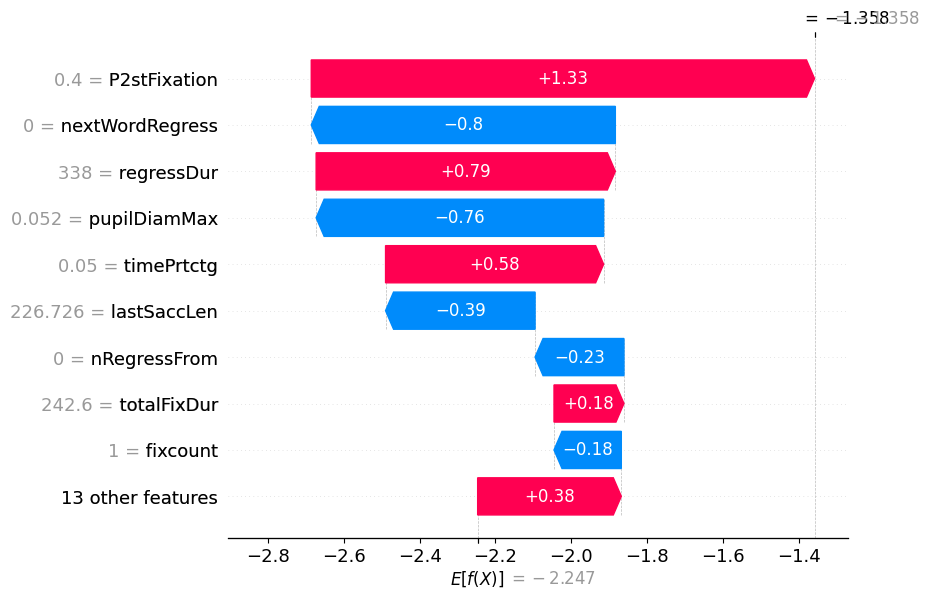

In [61]:
## explaination of a single prediction

## try with 0 , 1 ,19 ,25 ,26
shap.plots.waterfall(shap_values[1])

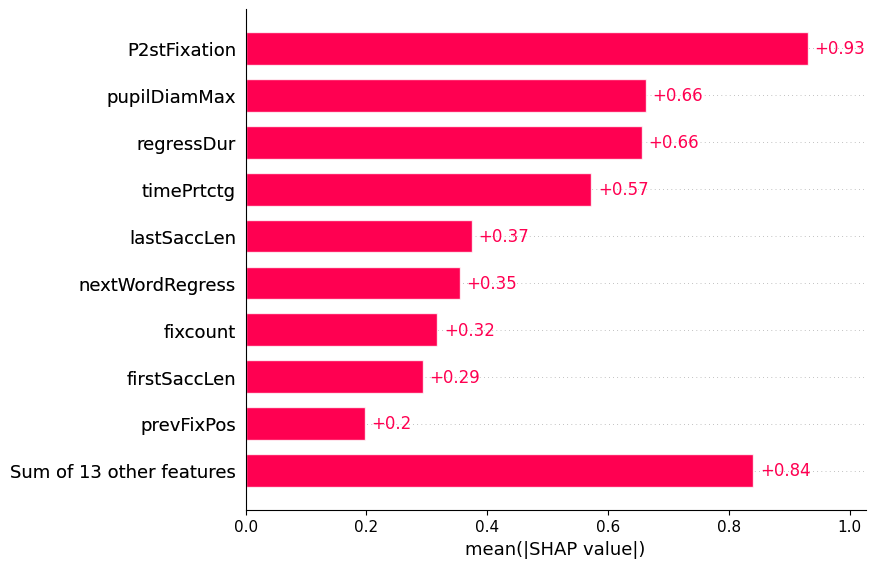

In [62]:
## average SHAP value over all predictions --> proxy of feature importance 
shap.plots.bar(shap_values)

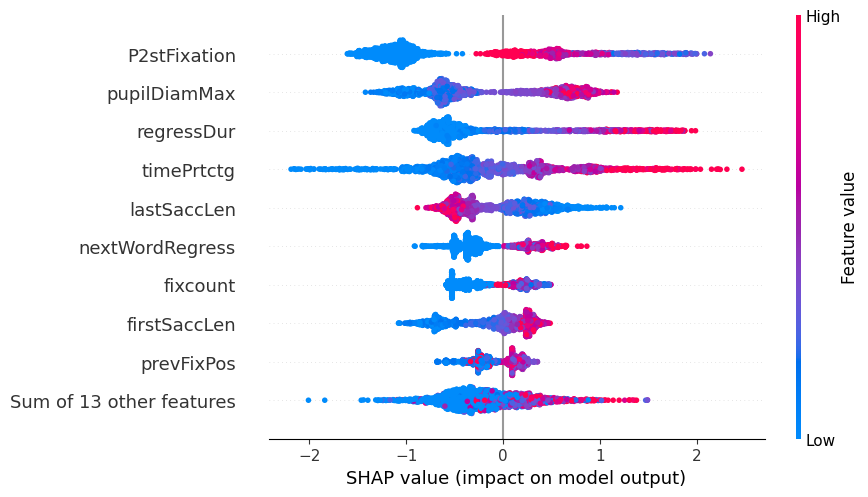

In [63]:
## beeswarm gives us a sense of the relationship between the feature values and the SHAP
shap.plots.beeswarm(shap_values)

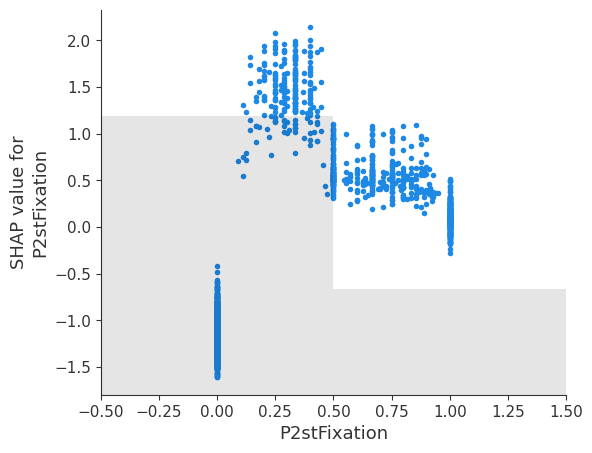

In [64]:
## plotting the SHAP value for each observed age
shap.plots.scatter( shap_values[:,'P2stFixation'] )

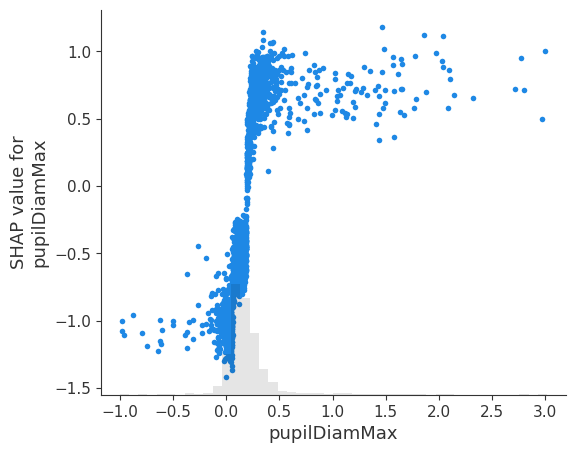

In [65]:
shap.plots.scatter( shap_values[:,'pupilDiamMax'] )

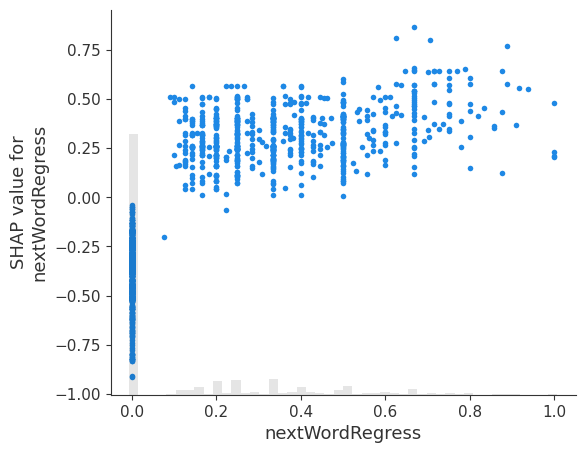

In [67]:
shap.plots.scatter( shap_values[:,'nextWordRegress'] )

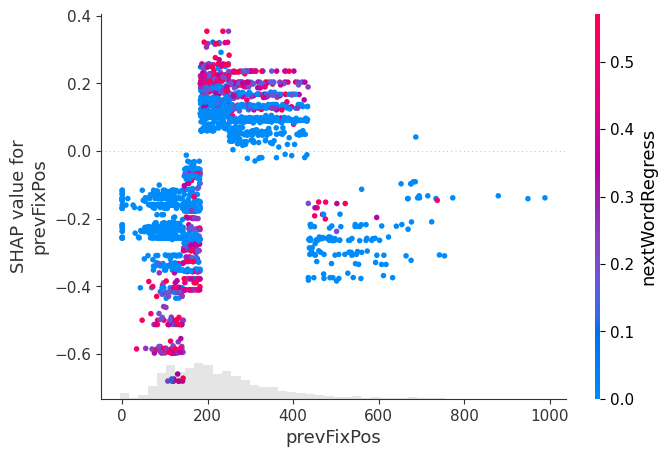

In [72]:
## visualize some of the interaction between feature by coloring according to another variable 
shap.plots.scatter( shap_values[:,'prevFixPos'] , color=shap_values )

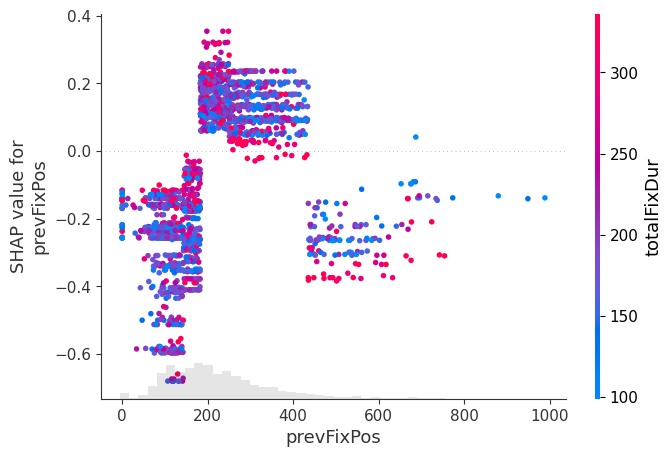

In [74]:
## If you give all shap_values, the library searched for the one which may interact the most
shap.plots.scatter( shap_values[:,'prevFixPos'] , color=shap_values[:,'totalFixDur'] )

## SHAP interaction values

In [75]:
%%time
shap_interaction_values = explainer.shap_interaction_values(X_train)

CPU times: user 6.24 s, sys: 0 ns, total: 6.24 s
Wall time: 883 ms


<Axes: >

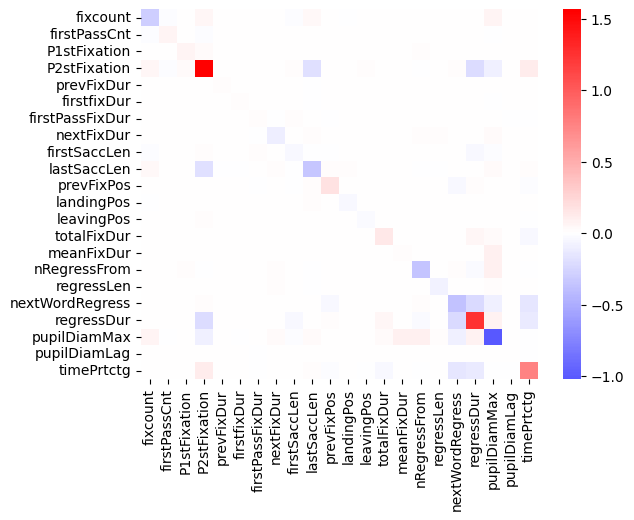

In [82]:
import seaborn as sns
sns.heatmap( shap_interaction_values[1], 
            xticklabels = X_train.columns,
            yticklabels = X_train.columns,
           center = 0, cmap = 'bwr')

In [77]:
shap_values[1].values

array([-1.7756888e-01,  2.7097683e-02,  1.1962985e-01,  1.3276274e+00,
        1.1596068e-02,  1.6991651e-02,  4.2337261e-02, -4.0934309e-03,
       -4.7441546e-02, -3.9444375e-01,  1.4989758e-01, -1.7496683e-02,
       -1.1796898e-02,  1.8452087e-01,  1.2240812e-01, -2.3446687e-01,
       -3.0119512e-02, -8.0220282e-01,  7.8932250e-01, -7.5841308e-01,
       -4.4986489e-05,  5.7529259e-01], dtype=float32)

In [78]:
shap_interaction_values[1].sum(axis = 1)

array([-1.7756890e-01,  2.7097683e-02,  1.1962985e-01,  1.3276277e+00,
        1.1596068e-02,  1.6991651e-02,  4.2337261e-02, -4.0934309e-03,
       -4.7441546e-02, -3.9444375e-01,  1.4989758e-01, -1.7496683e-02,
       -1.1796898e-02,  1.8452087e-01,  1.2240812e-01, -2.3446688e-01,
       -3.0119509e-02, -8.0220282e-01,  7.8932250e-01, -7.5841308e-01,
       -4.4986489e-05,  5.7529259e-01], dtype=float32)

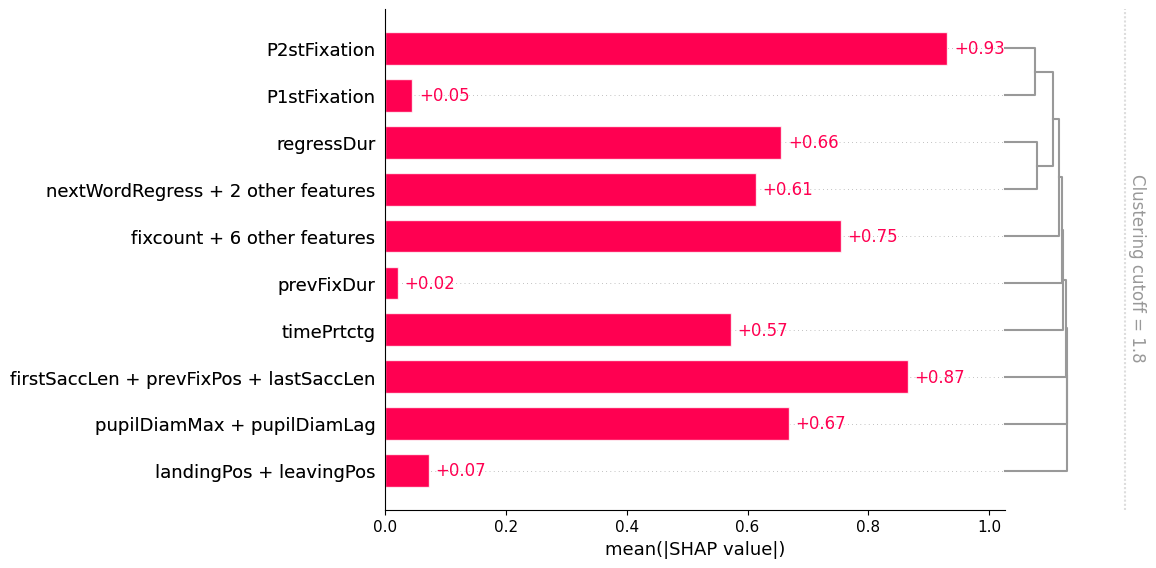

In [83]:
clustering = shap.utils.hclust(X_train, y_train)
shap.plots.bar(shap_values, clustering=clustering,clustering_cutoff=1.8)

## exercise

We train a similar model, but with max_depth fixed to 1.

Look at the corresponding SHAP values. What do you see?


In [85]:
model_xgb2 = xgboost.XGBClassifier(n_estimators=100, 
                                  max_depth=1,
                                  early_stopping_rounds=10 ,
                                  eval_metric= 'auc')
model_xgb2.fit(X_train, y_train, 
              eval_set=[(X_train, y_train),(X_valid, y_valid)],
              verbose=True)


[0]	validation_0-auc:0.74323	validation_1-auc:0.74789
[1]	validation_0-auc:0.84666	validation_1-auc:0.83723
[2]	validation_0-auc:0.86877	validation_1-auc:0.85081
[3]	validation_0-auc:0.86917	validation_1-auc:0.84711
[4]	validation_0-auc:0.89509	validation_1-auc:0.85992
[5]	validation_0-auc:0.89850	validation_1-auc:0.86024
[6]	validation_0-auc:0.91571	validation_1-auc:0.89059
[7]	validation_0-auc:0.92358	validation_1-auc:0.89890
[8]	validation_0-auc:0.92255	validation_1-auc:0.89514
[9]	validation_0-auc:0.93053	validation_1-auc:0.90817
[10]	validation_0-auc:0.92999	validation_1-auc:0.90587
[11]	validation_0-auc:0.93493	validation_1-auc:0.90596
[12]	validation_0-auc:0.93743	validation_1-auc:0.90507
[13]	validation_0-auc:0.94315	validation_1-auc:0.91945
[14]	validation_0-auc:0.94105	validation_1-auc:0.91743
[15]	validation_0-auc:0.94355	validation_1-auc:0.92475
[16]	validation_0-auc:0.94278	validation_1-auc:0.92267
[17]	validation_0-auc:0.94505	validation_1-auc:0.92745
[18]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [86]:
explainer2 = shap.Explainer( model_xgb2 ) ## creates an explainer from our model
shap_values2 = explainer2(X_train) ## compute shap values for the prediction of the models on some data

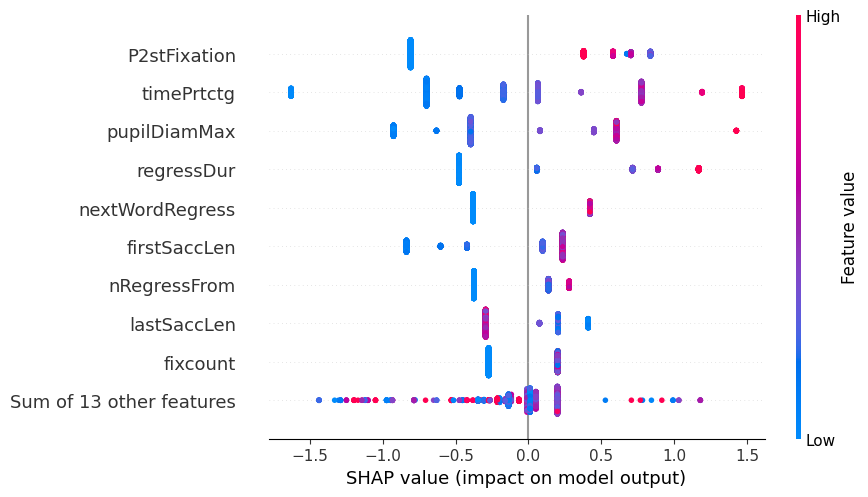

In [87]:
shap.plots.beeswarm(shap_values2)

## different explainer types

In [92]:
%%time
explainer = shap.Explainer( model_xgb2 ) ## defaults to TreeExplainer
print(type(explainer))
# TreeExplainer: 
#  * explores the tree ensemble to compute the SHAP values efficiently
#  * somewhat built-in the trees libraries nowadays -> extra fast computation
shap_values = explainer(X_train) 


<class 'shap.explainers._tree.TreeExplainer'>
CPU times: user 446 ms, sys: 3.76 ms, total: 450 ms
Wall time: 75.1 ms


In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


Xt_scaled = StandardScaler().fit_transform(X_train)

LR = LogisticRegression()
LR.fit(Xt_scaled, y_train)


LogisticRegression()

In [94]:
%%time

explainer = shap.Explainer( LR ) 
shap_values = explainer(Xt_scaled) 

explainer

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: LogisticRegression()

In [95]:
%%time
explainer = shap.Explainer( LR.predict_proba , Xt_scaled[:100,:] ) 
shap_values = explainer(Xt_scaled[:100,:]) 

explainer

CPU times: user 2.63 s, sys: 28.2 ms, total: 2.66 s
Wall time: 2.71 s


[permutation explainer](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/explainers/Permutation.html)
 * uses smart permutation scheme to estimate SHAP values
 * needs a "background" sample which is used to "simulate" values for the masked features

An alternative is to explicitely say that it is a Linear model:

In [96]:
%%time
# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(LR, Xt_scaled[:100,:])
shap_values = explainer(Xt_scaled[:100,:])

CPU times: user 17.5 ms, sys: 22 μs, total: 17.5 ms
Wall time: 15.6 ms


In [97]:
explainer

But in some case you won't have a choice and you need to go for a "generic" explainer such as PermutationExplainer

For example, for a KNN:

In [98]:
%%time 
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors=10)
KNN.fit(Xt_scaled, y_train)


explainer = shap.Explainer( KNN.predict_proba , Xt_scaled[:100,:]) 
shap_values = explainer(Xt_scaled[:100,:]) 

PermutationExplainer explainer: 101it [00:28,  2.33it/s]                                                                                                                                 

CPU times: user 1min 51s, sys: 54.5 ms, total: 1min 51s
Wall time: 28.3 s


See the API documentation for [other "explainers"](https://shap.readthedocs.io/en/latest/api.html#explainers), either generic or adapted to specific kind of models.


## causation, correlation, and interpretation of predictive models

We are sure you have heard it a large number of time, but this message really is really worth repeating.

The SHAP documentation actually proposes an [insightful article](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/Be%20careful%20when%20interpreting%20predictive%20models%20in%20search%20of%20causal%20insights.html) on the topic of misleading interpretation.

Our advise is to read it attentively, meditate on the subject, and then read it again.

